In [133]:
from matplotlib import pyplot
from pandas import DataFrame, concat, to_numeric,concat
from pandas import read_csv
from glob import glob
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, RNN
import sklearn.preprocessing

    open   close    i_open   i_close
0  650.0  635.65  16210.37  16008.34
1  628.1  641.00  15868.96  16123.46
2  657.0  655.85  16555.93  16483.45
3  660.0  667.15  16493.98  16846.83
4  666.0  661.65  16812.30  16805.33


C:\Users\Admin\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


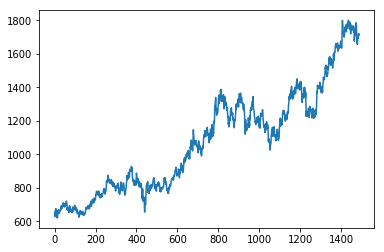

In [134]:
# Loading the dataset
def load_dataset(file_name):
    dataset = read_csv(file_name,index_col=False)
    dataset.columns=['symbol','date','open','high','low','close','volume','name','i_open','i_high','i_low','i_close']
    #print(dataset.head(5))
    dataset.drop(['symbol','date','high','low','volume','name','i_high','i_low'],1,inplace=True)
    dataset.convert_objects(convert_numeric=True)
    return dataset
dataset = load_dataset('500010.txt')
print(dataset.head(5))
pyplot.plot(dataset['open'])
pyplot.show()
 

In [135]:
# preparing for the LSTM

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

vals = 0
for i in glob('*.txt'):
    print(i)
    dataset = load_dataset(i)
    values = dataset.values

    # ensure all data is float
    values = values.astype('float64')
    # normalize features
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1) # 3 days of input output of 
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[4,6,7]], axis=1, inplace=True)
    if(type(vals) == int):
        vals = reframed
    else:
        vals = vals.append(reframed)
    #print(vals.shape)
print(vals.head(5))

500010.txt
500124.txt
500180.txt
500182.txt
500209.txt
500312.txt
500510.txt
500520.txt
500696.txt
500820.txt
500875.txt
532174.txt
532187.txt
532215.txt
532454.txt
532500.txt


C:\Users\Admin\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


532555.txt
532921.txt
532977.txt
533278.txt
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var2(t)
1   0.025506   0.014171   0.042205   0.044905  0.018711
2   0.006949   0.018711   0.023595   0.051109  0.031312
3   0.031438   0.031312   0.061042   0.070509  0.040901
4   0.033980   0.040901   0.057665   0.090092  0.036234
5   0.039064   0.036234   0.075017   0.087855  0.046459


In [136]:
# split into train and test sets
reframed = vals
values = reframed.values
n_train_hours = int(0.8*reframed.shape[0])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(23808, 1, 4) (23808,) (5952, 1, 4) (5952,)


Train on 23808 samples, validate on 5952 samples
Epoch 1/20
 - 7s - loss: 0.0332 - val_loss: 0.0207
Epoch 2/20
 - 5s - loss: 0.0127 - val_loss: 0.0199
Epoch 3/20
 - 5s - loss: 0.0124 - val_loss: 0.0194
Epoch 4/20
 - 5s - loss: 0.0123 - val_loss: 0.0207
Epoch 5/20
 - 7s - loss: 0.0122 - val_loss: 0.0216
Epoch 6/20
 - 6s - loss: 0.0121 - val_loss: 0.0218
Epoch 7/20
 - 7s - loss: 0.0120 - val_loss: 0.0215
Epoch 8/20
 - 7s - loss: 0.0120 - val_loss: 0.0214
Epoch 9/20
 - 8s - loss: 0.0119 - val_loss: 0.0208
Epoch 10/20
 - 7s - loss: 0.0118 - val_loss: 0.0205
Epoch 11/20
 - 6s - loss: 0.0118 - val_loss: 0.0206
Epoch 12/20
 - 6s - loss: 0.0117 - val_loss: 0.0197
Epoch 13/20
 - 6s - loss: 0.0117 - val_loss: 0.0212
Epoch 14/20
 - 6s - loss: 0.0116 - val_loss: 0.0190
Epoch 15/20
 - 8s - loss: 0.0115 - val_loss: 0.0198
Epoch 16/20
 - 7s - loss: 0.0116 - val_loss: 0.0199
Epoch 17/20
 - 5s - loss: 0.0115 - val_loss: 0.0195
Epoch 18/20
 - 6s - loss: 0.0115 - val_loss: 0.0195
Epoch 19/20
 - 5s - loss

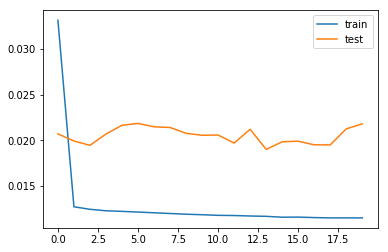

In [138]:
# design network
model = Sequential()
#model.add(Dense(40, input_shape=(40,), kernel_initializer='normal', activation='relu'))
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(2,kernel_initializer='normal', activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

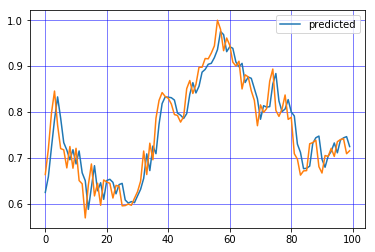

In [139]:
pyplot.grid(color='b', linestyle='-', linewidth=0.5)
pyplot.plot(model.predict(test_X[:100]))
pyplot.legend(['predicted'])
pyplot.plot(test_y[:100])
pyplot.show()
